![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

In [50]:
#importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text, MetaData , Table

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [12]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [37]:
#Lendo e atribuindo as tabelas para as variaveis criada abaixo
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)


In [16]:
#fazendo um banco de dados local
engine = create_engine('sqlite:///:memory:')

In [ ]:
#adicionando as tabelas no banco de dados e desabilitando o index
produtos.to_sql('produtos', engine,index=False)
pedidos.to_sql('pedido', engine,index=False)
itens_pedidos.to_sql('itens_pedidos', engine,index=False)
vendedores.to_sql('vendedores', engine,index=False)

In [52]:
#Verificando se as tabelas foram adicionadas
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedido', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [21]:
#Criando uma string para fazer
query = 'SELECT CONDICAO FROM PRODUTOS'

Codigo utilizando pandas e dataframe

pd.DataFrame(produtos['Condicao'])


In [22]:
#fazendo a condição da engine com nossa query
with engine.connect() as conexao:
    #consulta vai receber o resultado da consulta
    consulta = conexao.execute(text(query))
    #coletando todas os dados da consulta e armazenando
    dados = consulta.fetchall()

#criando o dataframe da consulta
pd.DataFrame(dados,columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [23]:
#criando uma função para fazer as consulta e gerar um dataframe da consulta
def sql_df(query):
    #fazendo a condição da engine com nossa query
    with engine.connect() as conexao:
        #consulta vai receber o resultado da consulta
        consulta = conexao.execute(text(query))
        #coletando todas os dados da consulta e armazenando
        dados = consulta.fetchall()
    #criando o dataframe da consulta
    return pd.DataFrame(dados,columns=consulta.keys())


In [32]:
query = '''SELECT CONDICAO,COUNT(*) AS Quantidade
FROM PRODUTOS
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


Codigo utilizando pandas e dataframe
produtos.groupby('Condicao').size().reset_index(name='Quantidade')


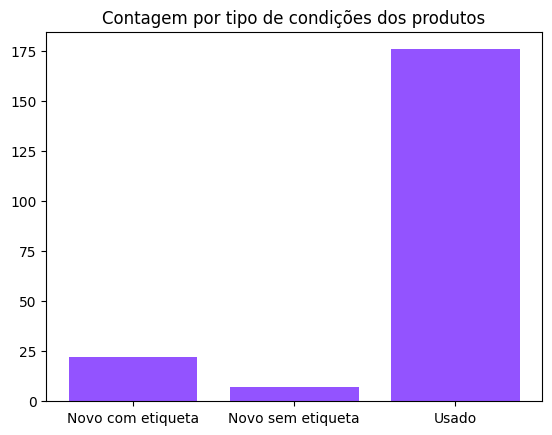

In [34]:
#criando uma visualização
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color = '#9353FF')
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [35]:
sql_df ('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [53]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


Codigo pandas
produtos.head(3)

itens_pedidos.head(3)


In [66]:
query = '''SELECT ITENS_PEDIDOS.PRODUTO_ID, PRODUTOS.PRODUTO, 
SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade   
FROM  PRODUTOS, ITENS_PEDIDOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_qtd= sql_df(query)
df_prod_qtd

,produto_id,produto,Quantidade
0,47682,Vestido Malha Estampa,318
1,84743,Blusa Listrada Malha,322
2,88368,Blusa Malha Azul,325
3,32986,Blusa Babados Off-white,337
4,2706,Blusa Cinza,341
...,...,...,...
196,32126,Saia Midi Cinto,549
197,47475,Calca Alfaiataria Preta,750
198,75557,Saia Pregas Preta,751
199,44424,Calca Jeans Costuras,755


Código em pandas
df_prod_quant = itens_pedidos.merge(produtos, on='produto_id')

df_prod_quant = df_prod_quant.groupby('produto')['quantidade'].sum().reset_index()

df_prod_quant = df_prod_quant.sort_values('quantidade', ascending=True).reset_index(drop=True)

df_prod_quant


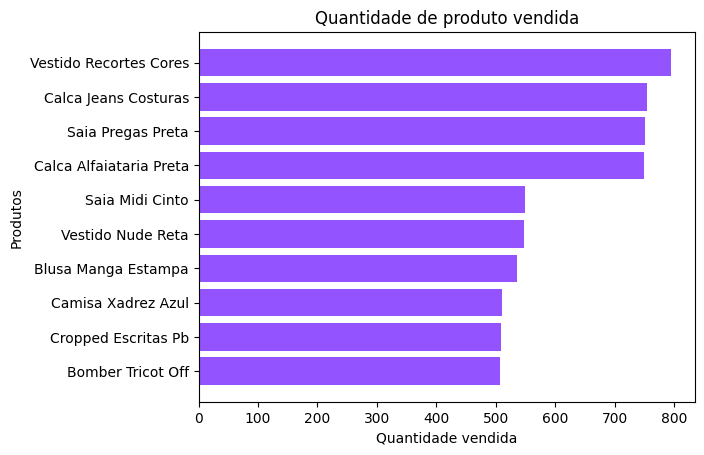

In [68]:
plt.barh(df_prod_qtd['produto'][-10:], df_prod_qtd['Quantidade'][-10:], color='#9353FF')
plt.title('Quantidade de produto vendida')
plt.xlabel('Quantidade vendida')
plt.ylabel('Produtos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [70]:
sql_df('SELECT * FROM PEDIDO').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [71]:
sql_df('SELECT * FROM PEDIDO').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [88]:
query = ''' SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDO.PEDIDO_ID) AS 'Quantidade venda'
FROM PEDIDO, VENDEDORES
WHERE STRFTIME('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDO.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDO.PEDIDO_ID) ASC;'''
sql_df(query)

,nome_vendedor,Quantidade venda
0,Paulo Calanca,2488
1,Millena Pereira,2510
2,Nadia Oliveira,2782
3,Daniel Siqueira,3338
4,Ana Duarte,3427


In [82]:
#OBTENDO A MÉDIA DE VENDAR POR VENDEDOR
query = ''' SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDO.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDO, VENDEDORES
WHERE STRFTIME('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDO.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDO.TOTAL) DESC;'''
sql_df(query)

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


Código com pandas

df_filtrado = pedidos[pedidos['data_compra'].str.startswith('2020')]

df_mesclado = df_filtrado.merge(vendedores, on='vendedor_id')

df_agrupado = df_mesclado.groupby('nome_vendedor')['total'].mean().reset_index()

df_filtro_data = df_agrupado.sort_values('total', ascending=False).reset_index(drop=True)

df_filtro_data.columns = ['nome_vendedor', 'Valor médio por vendas']

df_filtro_data


MAX()

Essa função de agregação permite encontrar o valor máximo em uma coluna específica de uma tabela, retornando esse valor.

In [84]:
query = '''
SELECT MAX(PRECO) AS PRECO_MAXIMO
FROM PRODUTOS;
'''

sql_df(query)

,PRECO_MAXIMO
0,6500


MIN()

Em contraste com a função MAX, a função MIN encontra o valor mínimo em uma coluna específica de uma tabela.

In [85]:
query = '''
SELECT MIN(PRECO) AS PRECO_MINIMO
FROM PRODUTOS;
'''
sql_df(query)

,PRECO_MINIMO
0,45


Como um exemplo, podemos usar dessas formatações para entender a distribuição de pedidos durante os meses do ano 2019 e 2020:

In [79]:
## Selecionar dados do ano de 2019
query = '''
SELECT strftime('%m', data_compra) AS mes, COUNT(*) AS quantidade_vendas
FROM pedido
WHERE strftime('%Y', data_compra) = '2019'
GROUP BY mes;
'''
vendas_19 = sql_df(query)
vendas_19


,mes,quantidade_vendas
0,01,141
1,02,333
2,03,501
3,04,456
4,05,650
5,06,567
6,07,738
7,08,745
8,09,802
9,10,866


In [78]:
## Selecionar dados do ano de 2020
query = '''
SELECT strftime('%m', data_compra) AS mes, COUNT(*) AS quantidade_vendas
FROM pedido
WHERE strftime('%Y', data_compra) = '2020'
GROUP BY mes;
'''
vendas_20 = sql_df(query)
vendas_20

,mes,quantidade_vendas
0,01,1271
1,02,1197
2,03,1280
3,04,1276
4,05,1206
5,06,896
6,07,984
7,08,1163
8,09,1221
9,10,1139


Depois de coletar os dados, podemos comparar os resultados com uma visualização.

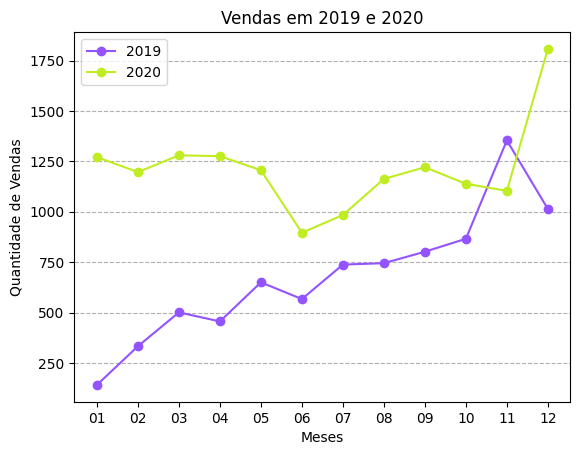

In [77]:

# Plotar o gráfico de 2019 e 2020
plt.plot(vendas_19.mes.to_numpy(), vendas_19.quantidade_vendas.to_numpy(), marker='o', linestyle='-', color='#9353FF', label = '2019')
plt.plot(vendas_20.mes.to_numpy(), vendas_20.quantidade_vendas.to_numpy(), marker='o', linestyle='-', color='#C0ED22', label = '2020')

# Definir título e eixos
plt.title('Vendas em 2019 e 2020')
plt.xlabel('Meses')
plt.ylabel('Quantidade de Vendas')

# Adicionar a legenda
plt.legend()

# Adicionar grid horizontal
plt.grid(axis='y', linestyle='--')

# Exibir a figura
plt.show()


## DESAFIO

Vamos aos desafios dessa aula, o primeiro é exibir os 10 produtos mais vendidos durante o ano de 2019, que podem ser representados em uma tabela. Já o segundo será publicar a distribuição através dos meses da receita obtida em vendas no ano de 2021. Busque mostrar essa distribuição colocando o mês e sua receita correspondente na visualização.

In [91]:
sql_df('SELECT * FROM PEDIDO')

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
...,...,...,...,...,...
24522,63716,64127,1,2021-03-09,2360
24523,63999,37384,2,2021-03-09,2800
24524,64594,100932,1,2021-03-10,19500
24525,64811,3820,3,2021-03-10,417


In [92]:
sql_df('SELECT * FROM PRODUTOS')

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248,Usado
...,...,...,...,...,...,...
200,14074,Camisa Amarela Laco,450,Carol Bassi,309858,Usado
201,33349,Vestido Listras Malha,270,Calvin Klein,307118,Usado
202,22568,Casaqueto Estampa Geometrica,245,Zara,244931,Usado
203,40508,Regata Bicolor Alcinha,245,Express,247166,Usado


In [102]:
query = ''' SELECT PRODUTOS.PRODUTO, COUNT(PEDIDO.PRODUTO_ID) AS 'Quantidade vendida'
FROM PEDIDO, PRODUTOS
WHERE STRFTIME('%Y', data_compra) = '2019' AND PRODUTOS.PRODUTO_ID = PEDIDO.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY COUNT(PEDIDO.PEDIDO_ID) DESC
LIMIT 10;'''

df_maior_qtd_vendida = sql_df(query)

Text(0, 0.5, 'Produtos')

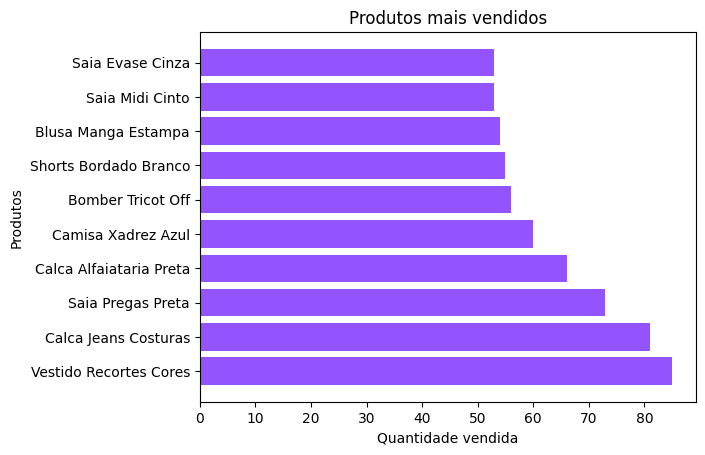

In [106]:
plt.barh(df_maior_qtd_vendida['produto'], df_maior_qtd_vendida['Quantidade vendida'], color='#9353FF')
plt.title('Produtos mais vendidos')
plt.xlabel('Quantidade vendida')
plt.ylabel('Produtos')

In [109]:
sql_df('SELECT * FROM PEDIDO')

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
...,...,...,...,...,...
24522,63716,64127,1,2021-03-09,2360
24523,63999,37384,2,2021-03-09,2800
24524,64594,100932,1,2021-03-10,19500
24525,64811,3820,3,2021-03-10,417


In [131]:
query = ''' 
SELECT STRFTIME('%m', DATA_COMPRA) AS MES, SUM(TOTAL) AS QTD_PEDIDOS
FROM PEDIDO
WHERE STRFTIME('%Y', DATA_COMPRA) = '2020'
GROUP BY MES;
'''

df_renda_mes = sql_df(query)
sql_df(query)

,MES,QTD_PEDIDOS
0,01,2458252
1,02,2168386
2,03,2472297
3,04,2189559
4,05,2168099
5,06,1577791
6,07,1881010
7,08,2268550
8,09,2428227
9,10,2079915


In [133]:
df_renda_mes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MES          12 non-null     object
 1   QTD_PEDIDOS  12 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 324.0+ bytes


Text(0, 0.5, 'Quantidade vendida')

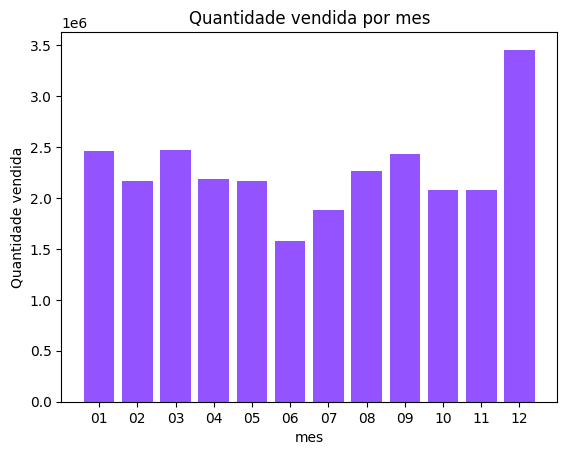

In [136]:
plt.bar(df_renda_mes['MES'], df_renda_mes['QTD_PEDIDOS'], color='#9353FF')
plt.title('Quantidade vendida por mes')
plt.xlabel('mes')
plt.ylabel('Quantidade vendida')


# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [139]:
sql_df('SELECT * FROM ITENS_PEDIDOS')

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0
...,...,...,...,...,...,...,...,...
24522,25051,64127,63716,4,590,2360,BR-PE,472.0
24523,25052,37384,63999,4,700,2800,BR-RO,560.0
24524,25053,100932,64594,5,3900,19500,BR-RO,3900.0
24525,25054,3820,64811,3,139,417,BR-MA,83.4


In [138]:
query = ''' SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;
'''
sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Codigo em Pandas

df_agrupados = itens_pedidos.groupby('Estado').size().reset_index(name='Pedidos')

df_estados = df_agrupados.sort_values('Pedidos', ascending=False).reset_index(drop=True)

df_estados


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [150]:
sql_df('SELECT * FROM PEDIDO')

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
...,...,...,...,...,...
24522,63716,64127,1,2021-03-09,2360
24523,63999,37384,2,2021-03-09,2800
24524,64594,100932,1,2021-03-10,19500
24525,64811,3820,3,2021-03-10,417


In [153]:
query = ''' SELECT PEDIDO.VENDEDOR_ID, COUNT(*) AS QUANTIDADE_VENDAS
FROM PEDIDO
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDO.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PEDIDO.VENDEDOR_ID
ORDER BY quantidade_vendas DESC;
'''

sql_df(query)

,vendedor_id,QUANTIDADE_VENDAS
0,2,190
1,5,182
2,3,181
3,1,180
4,4,157


In [154]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT(*) AS produtos_pedidos
FROM ITENS_PEDIDOS
JOIN PRODUTOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-PI'
GROUP BY PRODUTOS.PRODUTO
ORDER BY produtos_pedidos DESC;
'''
df_prod_piaui = sql_df(query)
df_prod_piaui

,produto,produtos_pedidos
0,Calca Jeans Off-white,12
1,Calca Jeans Costuras,11
2,Calca Costuras Bege,11
3,Sandalia Nude Vazado,10
4,Saia Roxa Estampada,10
...,...,...
191,Saia Transparente Cover,1
192,Saia Fio Nude,1
193,Oculos Metal,1
194,Cropped Escritas Pb,1


In [156]:
query = ''' SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS QUANTIDADE_VENDAS
FROM PEDIDO
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDO.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDO.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC;
'''

sql_df(query)

,nome_vendedor,QUANTIDADE_VENDAS
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157


codigo com pandas

df_unido = pedidos.merge(vendedores, on='vendedor_id').merge(itens_pedidos, on='pedido_id')

df_filtrado = df_unido.query("Estado == 'BR-SP'")

df_vendedores_sp = df_filtrado.groupby('nome_vendedor').size().reset_index(name='quantidade_vendas')

df_vendedores_sp = df_vendedores_sp.sort_values('quantidade_vendas', ascending=False)

df_vendedores_sp


In [159]:
sql_df('SELECT * FROM ITENS_PEDIDOS')

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0
...,...,...,...,...,...,...,...,...
24522,25051,64127,63716,4,590,2360,BR-PE,472.0
24523,25052,37384,63999,4,700,2800,BR-RO,560.0
24524,25053,100932,64594,5,3900,19500,BR-RO,3900.0
24525,25054,3820,64811,3,139,417,BR-MA,83.4


In [163]:
sql_df('SELECT * FROM PEDIDO')

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
...,...,...,...,...,...
24522,63716,64127,1,2021-03-09,2360
24523,63999,37384,2,2021-03-09,2800
24524,64594,100932,1,2021-03-10,19500
24525,64811,3820,3,2021-03-10,417


In [162]:
sql_df('SELECT * FROM PRODUTOS')

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248,Usado
...,...,...,...,...,...,...
200,14074,Camisa Amarela Laco,450,Carol Bassi,309858,Usado
201,33349,Vestido Listras Malha,270,Calvin Klein,307118,Usado
202,22568,Casaqueto Estampa Geometrica,245,Zara,244931,Usado
203,40508,Regata Bicolor Alcinha,245,Express,247166,Usado


In [167]:
query = ''' SELECT PRODUTOS.MARCA, COUNT(*) AS QUANTIDADE_VENDAS
FROM PEDIDO
JOIN PRODUTOS ON PEDIDO.PRODUTO_ID = PRODUTOS.PRODUTO_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDO.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY quantidade_vendas DESC;
'''

sql_df(query)

,marca,QUANTIDADE_VENDAS
0,Zara,100
1,Mixed,58
2,Animale,44
3,Le Lis Blanc,26
4,Banana Republic,18
...,...,...
111,Topshop,1
112,Morena Rosa,1
113,Erre Erre,1
114,Bobô,1


In [169]:
query = ''' SELECT PRODUTOS.PRODUTO, COUNT(*) AS QUANTIDADE_VENDAS
FROM PEDIDO
JOIN PRODUTOS ON PEDIDO.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE STRFTIME('%m', pedido.DATA_COMPRA) = '12'
GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade_vendas DESC;
'''
sql_df(query)

,produto,QUANTIDADE_VENDAS
0,Vestido Recortes Cores,30
1,Vestido Preto Franzido,26
2,Calca Jeans Costuras,26
3,Calca Alfaiataria Preta,26
4,Camisa Xadrez Azul,25
...,...,...
196,Sneaker Monograma Bege,6
197,Casaqueto Estampa Geometrica,6
198,Regata Renda Branca,5
199,Body Estampa Coracoes,5
